# Import and misc

In [13]:
%pip install torchaudio==0.9.1

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 2.5 MB/s 
     |████████████████████████████████| 831.4 MB 2.0 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.4.0 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
enot-utils 1.0.2 requires torch==1.6.0, but you have torch 1.9.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [14]:
#!g1.1
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

torch.manual_seed(42)
np.random.seed(42)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [15]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [16]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-17 21:47:18--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.1.128, 2a00:1450:4010:c1e::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.1.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   130MB/s    in 12s     

2021-11-17 21:47:30 (118 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [17]:
#!g1.1
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [18]:
#!g1.1
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [19]:
#!g1.1
dataset.csv.sample(5)

,path,keyword,label
10752,speech_commands/one/190821dc_nohash_4.wav,one,0
13604,speech_commands/left/dca6b373_nohash_1.wav,left,0
40091,speech_commands/six/b9f46737_nohash_3.wav,six,0
34633,speech_commands/two/dbb40d24_nohash_0.wav,two,0
39923,speech_commands/down/25040e85_nohash_0.wav,down,0


### Augmentations

In [20]:
#!g1.1
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [21]:
#!g1.1
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [22]:
#!g1.1
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [23]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)
#!g1.1

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [24]:
#!g1.1
train_sampler = get_sampler(train_set.csv['label'].values)

In [25]:
#!g1.1
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [65]:
#!g1.1
# wtf is going on in this cell? Nothing special, just Datasphere things.

# Here we are obliged to use shuffle=False because of our sampler with randomness inside.
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=0, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=0, pin_memory=True)

next(iter(train_loader))
next(iter(val_loader))

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [27]:
#!g1.1
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [28]:
#!g1.1
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [29]:
#!g1.1
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [30]:
#!g1.1
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [76]:
#!g1.1
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        return self.energy(input) 

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        energy = self.attention(gru_output)
        alpha = torch.softmax(energy, dim=-2)
        contex_vector = (gru_output * alpha).sum(dim=-2)
        output = self.classifier(contex_vector)
        return output
config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
#!g1.1
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [33]:
#!g1.1
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [34]:
#!g1.1
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [35]:
#!g1.1
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
#!g1.1
sum([p.numel() for p in model.parameters()])

70443

In [37]:
#!g1.1
# TRAIN
if False:
    for n in range(1, TaskConfig.num_epochs + 1):

        train_epoch(model, opt, train_loader,
                    melspec_train, config.device)

        au_fa_fr = validation(model, val_loader,
                              melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

    assert (history['val_metric'][-1] - 0.00005) <= 5e-6, "Quality is not good enough"
    torch.save(model.state_dict(), "model.pt")

In [48]:
#!g1.1
model.load_state_dict(torch.load("model.pt"))
model.eval();

# Streaming

In [39]:
#!g1.1
import sys

class StreamingKWS(CRNN):
    def  __init__(self, config, window_length, step=1):
        super().__init__(config)
        
        self.window_len = window_length
        self.step = max(config.stride[1], step)
        self.kernel_size = self.config.kernel_size[1]
        self.reset()

    def forward(self, input: torch.tensor) -> List[float]:
        '''
        input:
          2d torch.tensor of shape (len, n_mels,)
        output:
          1d list of floats of shape (S,)
          where S = (L + len - kernel_size[1]) // stride[1] - (L - kernel_size[1]) // stride[1])
          where L -- sum of previous inputs lens
        '''
        outputs = []

        input = input.unsqueeze(dim=0).unsqueeze(dim=0)
        self.input_buffer = torch.cat((self.input_buffer, input), dim=-1)
        
        if self.input_buffer.size(-1) < self.kernel_size:
            print(f"Provide {self.kernel_size-self.input_buffer.size(-1)} more observations to have next prediction.", file=sys.stderr)
            return []
        for i in range(self.kernel_size, self.input_buffer.size(-1)+1, self.step):
            input_ = self.input_buffer[:,:,:,i-self.kernel_size:i]
            conv_output = self.conv(input_).transpose(-1, -2)
            gru_output, self.hidden = self.gru(conv_output, self.hidden)
            
            energy = self.attention(gru_output)
            self.energy_buffer = torch.cat((self.energy_buffer, energy), dim=1)[:,-self.window_len:]
            alpha = torch.softmax(self.energy_buffer, dim=-2)
            contex_vector = (alpha * gru_output).sum(dim=-2)
            output = self.classifier(contex_vector)
            output = F.softmax(output, dim=-1)
            outputs.append(output[0,1].item())
        self.input_buffer = self.input_buffer[:,:,:,i-self.kernel_size+self.step:]
        return outputs
    def reset(self):
        '''
        call this function before passing new audio stream
        '''
        self.input_buffer = torch.zeros((1, 1, self.config.n_mels, 0), device=self.config.device)
        self.energy_buffer = torch.zeros((1, self.window_len, 1), device=self.config.device)
        self.hidden = None


In [40]:
#!g1.1
step = 8
window_size = 30
streaming_model = StreamingKWS(model.config, window_size, step).to(model.config.device)
streaming_model.load_state_dict(torch.load("model.pt"))
streaming_model.eval();

In [41]:
#!g1.1
streaming_model.reset()
device=model.config.device
for batch, labels in train_loader:
    n = 8
    batch, _labels = batch[0:n], labels[0:n]
    batch = melspec_val(batch.to(device))
    output_ = torch.softmax(model(batch).detach().cpu(), dim=-1)[:,1]
    labels = [torch.zeros(batch[i].size(-1)//step) + _labels[i] for i in range(n)]
    labels = torch.cat(labels, dim=0).cpu().numpy()
    output_ = [torch.zeros(batch[i].size(-1)//step) + output_[i] for i in range(n)]
    output_ = torch.cat(output_, dim=0).numpy()
    batch = batch.transpose(0, 1).flatten(start_dim=1)

    output = []
    for i in range(step, batch.size(1)-1, step):
        b = batch[:,i-step:i]
        output += streaming_model(b)
    print(_labels)
    plt.plot(labels, '--', label='target', alpha=0.5)
    plt.plot(output, label='Streaming prediction', alpha=1)
    plt.plot(output_, label='Straightforward prediction', alpha=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    break

# Dark knowledge distillation

In [42]:
#!g1.1
# TRAIN
def train(model, config, history=defaultdict(list), model_name=None, last_epoch=0):
    for n in range(last_epoch+1, config.num_epochs + 1):

        train_epoch(model, opt, train_loader,
                    melspec_train, config.device)

        au_fa_fr = validation(model, val_loader,
                              melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)
        if (history['val_metric'][-1] - 1.1*5e-5) <= 5e-6:
            break          

    if model_name is not None:
        torch.save(model.state_dict(), f"{model_name}.pt")
    assert (history['val_metric'][-1] - 1.1*5e-5) <= 5e-6, "Quality is not good enough"

In [43]:
#!g1.1
small_config = TaskConfig()
small_config.hidden_size = 32
small_config.num_epochs = 50
small_model = CRNN(small_config).to(device)

history = defaultdict(list)
opt = torch.optim.Adam(
    small_model.parameters(),
    lr=small_config.learning_rate,
    weight_decay=small_config.weight_decay
)

print(sum([p.numel() for p in small_model.parameters()]))
print(small_model)

25387
CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


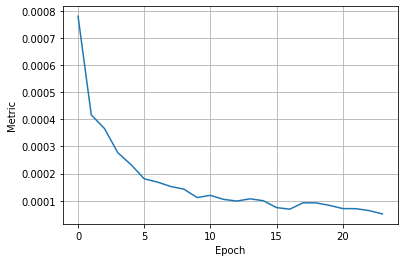

END OF EPOCH 24


In [44]:
#!g1.1
train(small_model, small_config, history, "small_model_32")

In [46]:
#!g1.1
small_config = TaskConfig()
small_config.hidden_size = 16
small_config.num_epochs = 50
small_model = CRNN(small_config).to(device)

history = defaultdict(list)
opt = torch.optim.Adam(
    small_model.parameters(),
    lr=small_config.learning_rate,
    weight_decay=small_config.weight_decay
)

print(sum([p.numel() for p in small_model.parameters()]))
print(small_model)

10539
CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


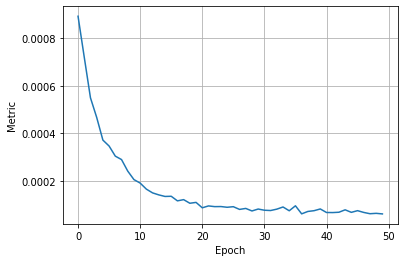

END OF EPOCH 50


AssertionError: Quality is not good enough

In [47]:
#!g1.1
train(small_model, small_config, history, "small_model_16")

In [55]:
#!g1.1
def train_epoch_with_teacher(model, teacher, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss_orig = F.cross_entropy(logits, labels)
        
        logits_teacher = model(batch).detach()
        probs_teacher = F.softmax(logits_teacher/20, dim=-1)
        loss_teacher = -(probs*probs_teacher).sum(dim=-1).mean()
        
        loss = loss_orig + loss_teacher
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train_with_teacher(model, teacher, config, history=defaultdict(list), model_name=None, last_epoch=0):
    for n in range(last_epoch+1, config.num_epochs + 1):

        train_epoch_with_teacher(model, teacher, opt, train_loader,
                    melspec_train, config.device)

        au_fa_fr = validation(model, val_loader,
                              melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)
        if (history['val_metric'][-1] - 1.1*5e-5) <= 5e-6:
            break          

    if model_name is not None:
        torch.save(model.state_dict(), f"{model_name}.pt")
    assert (history['val_metric'][-1] - 1.1*5e-5) <= 5e-6, "Quality is not good enough"

In [60]:
#!g1.1
small_config = TaskConfig()
small_config.hidden_size = 16
small_config.num_epochs = 100
small_model = CRNN(small_config).to(device)

history = defaultdict(list)
opt = torch.optim.Adam(
    small_model.parameters(),
    lr=small_config.learning_rate,
    weight_decay=small_config.weight_decay
)

print(sum([p.numel() for p in small_model.parameters()]))
print(small_model)

10539
CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


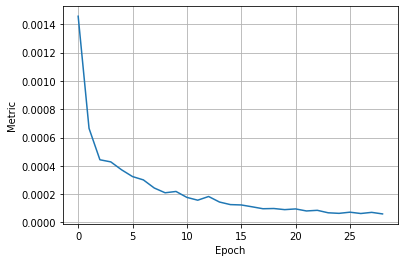

END OF EPOCH 29


In [61]:
#!g1.1
train_with_teacher(small_model, model, small_config, history, "small_model_16")

In [63]:
#!g1.1
small_config = TaskConfig()
small_config.hidden_size = 10
small_config.num_epochs = 50
small_model = CRNN(small_config).to(device)

history = defaultdict(list)
opt = torch.optim.Adam(
    small_model.parameters(),
    lr=small_config.learning_rate,
    weight_decay=small_config.weight_decay
)

print(sum([p.numel() for p in small_model.parameters()]))
print(small_model)

6291
CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 10, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)


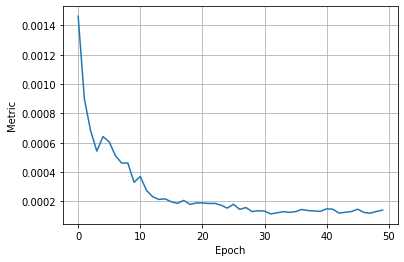

END OF EPOCH 50


AssertionError: Quality is not good enough

In [66]:
#!g1.1
train_with_teacher(small_model, model, small_config, history, "small_model_10")

# Quantization

In [102]:
#!g1.1
model_fp32

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [106]:
#!g1.1
# define a floating point model where some layers could be statically quantized

# create a model instance
model_fp32 = CRNN(config)
model_fp32.load_state_dict(torch.load('model.pt'))

# model must be set to eval mode for static quantization logic to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'fbgemm' for server inference and
# 'qnnpack' for mobile inference. Other quantization configurations such
# as selecting symmetric or assymetric quantization and MinMax or L2Norm
# calibration techniques can be specified here.
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
model_fp32_fused = torch.quantization.fuse_modules(model_fp32, [['classifier']])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.quantization.prepare(model_fp32_fused)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
input_fp32 = torch.randn(4, 1, 4, 4)
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
res = model_int8(input_fp32)

AssertionError: did not find fuser method for: (<class 'torch.nn.modules.linear.Linear'>,) 

In [ ]:
#!g1.1


# Testing

In [68]:
%pip install thop

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [70]:
#!g1.1
import time
class Timer:
    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")


from thop import profile

def get_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)


In [78]:
#!g1.1
sample_input = torch.rand(1, 1, model.config.n_mels, 100)
profile(CRNN(model.config), sample_input)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(933808.0, 70443.0)

In [100]:
#!g1.1
profile(model_int8, sample_input)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

(159984.0, 808.0)

In [80]:
#!g1.1
get_size_in_megabytes(model)

0.2687187194824219

In [83]:
#!g1.1
small_config = TaskConfig()
small_config.hidden_size = 16
sample_input = torch.rand(1, 1, model.config.n_mels, 100)
profile(CRNN(small_config), sample_input)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(268960.0, 10539.0)

In [85]:
#!g1.1
small_model = CRNN(small_config)
small_model.load_state_dict(torch.load('small_model_16.pt'))
get_size_in_megabytes(small_model)

0.040203094482421875

In [86]:
!ls -lh

total 1.4G
-rw-r--r-- 1 jupyter jupyter 5.0K Nov 17 21:40 README.md
-rw-r--r-- 1 jupyter jupyter 108K Nov 19 08:45 kws.ipynb
-rw-r--r-- 1 jupyter jupyter 1.8M Nov 17 21:52 log
-rw-r--r-- 1 jupyter jupyter 279K Nov 17 21:40 model.pt
-rw-r--r-- 1 jupyter jupyter  45K Nov 18 15:38 small_model_16.pt
-rw-r--r-- 1 jupyter jupyter 103K Nov 17 22:16 small_model_32.pt
-rw-r--r-- 1 jupyter jupyter  29K Nov 19 07:45 small_model_8.pt
drwxr-x--- 1 jupyter jupyter  364 Apr 11  2018 speech_commands
-rw-r--r-- 1 jupyter jupyter 1.4G Apr 11  2018 speech_commands_v0.01.tar.gz
